# DREEM Sleep Stage Classification Report
In this report, we look at methods used for data preprocessing, feature extraction, classifiers used and results for the DREEM Sleep Stage Classification Challenge. We further use boosting methods such as Light GBM, XGBoost and Majority Voting to improve the accuracy of the model as given by the pipeline below.
### Done by Hayagreev Sivakumar
Achieved 70.388% accuracy in the Leaderboards.

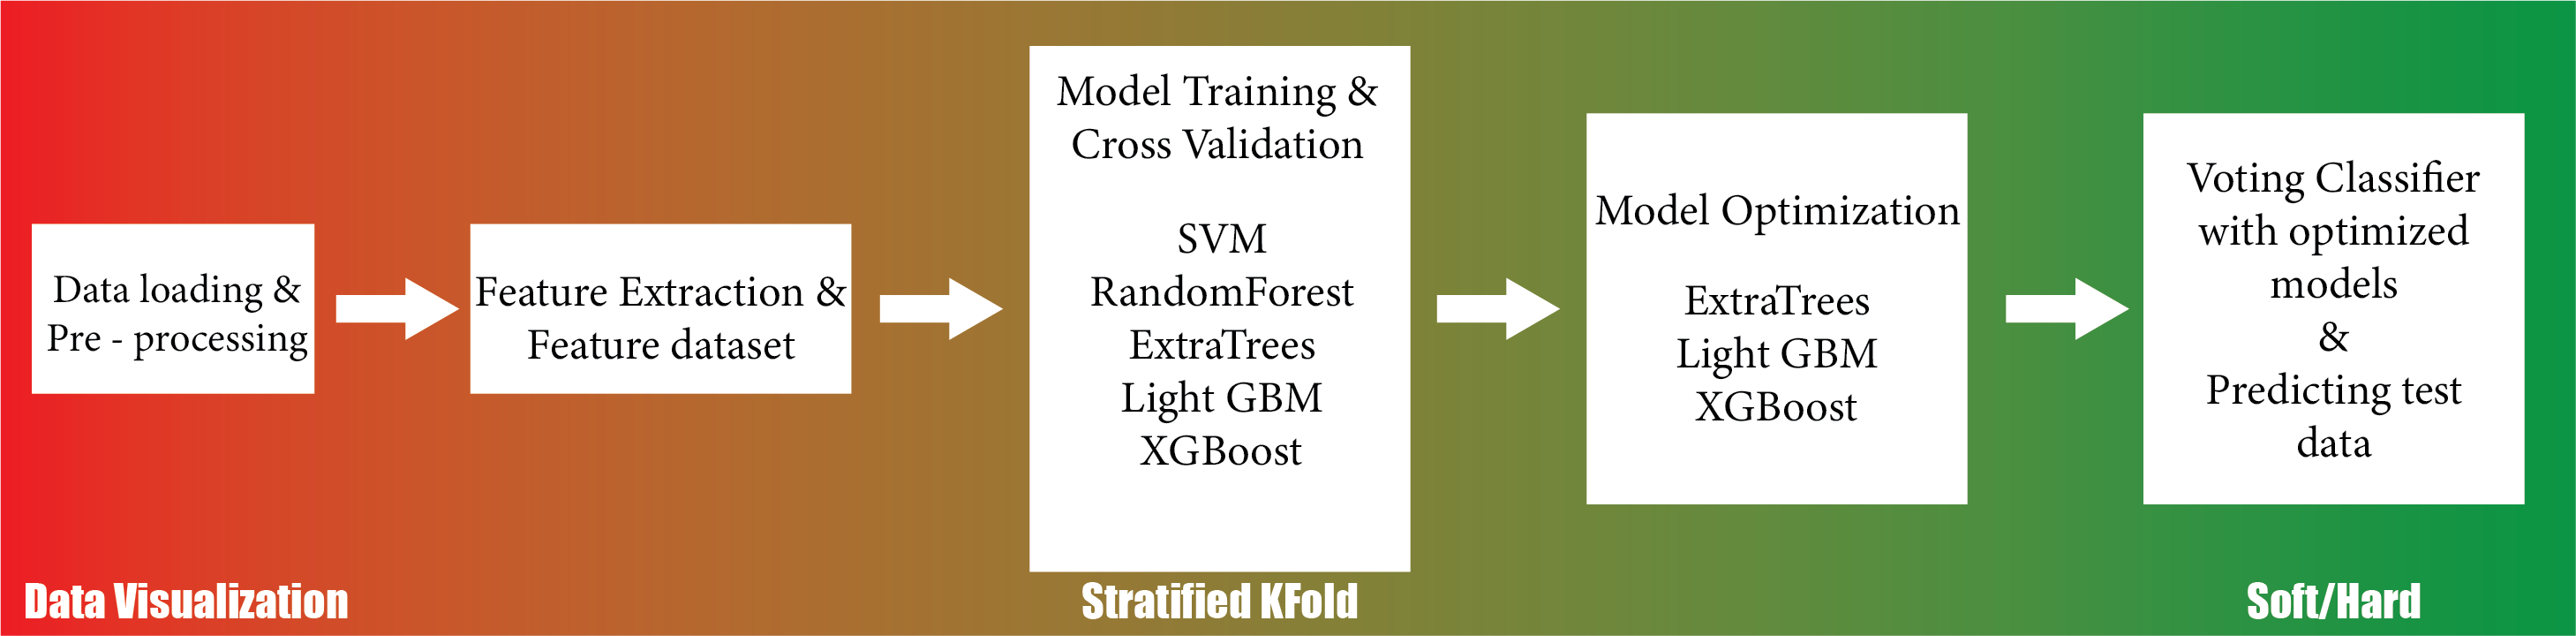

                                        Fig 1. Pipeline of Sleep Stage Classification

## Importing necessary packages

In [1]:
import os as sys

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sc
from scipy.signal import butter, lfilter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

from tsfresh.feature_extraction import feature_calculators as fc

import tqdm.notebook as tq

ModuleNotFoundError: No module named 'xgboost'

## Data Preprocessing : Functions for filtering the signal
In our model, we preprocess the data by filtering the 30 second signal to obtain the different constituents which make up the signal. A sleep signal EEG consists of 5 different signals with different frequency bands $\delta$ : $0.5-4$Hz ,$\theta$ : $4-8$Hz,$\alpha$ : $8-13$Hz,$\beta$ : $13-22$Hz and $\gamma$ : $>30$Hz. 

The sleep stages vary with time putting us into deep sleep at one point and near waking stage at another. Approx time taken for a sleep cycle is 90mins and we go through all the stages of sleep during one cycle.

Stages of Sleep classified:

$\bullet$ Wake : Consists of alpha and beta waves. (0)

$\bullet$ N1 : Consists of theta waves. (1)

$\bullet$ N2 : Consists of theta waves with K-complex and spindles. (2)

$\bullet$ N3 : Delta waves. (3)

$\bullet$ REM : Sawtooth waves. (4)

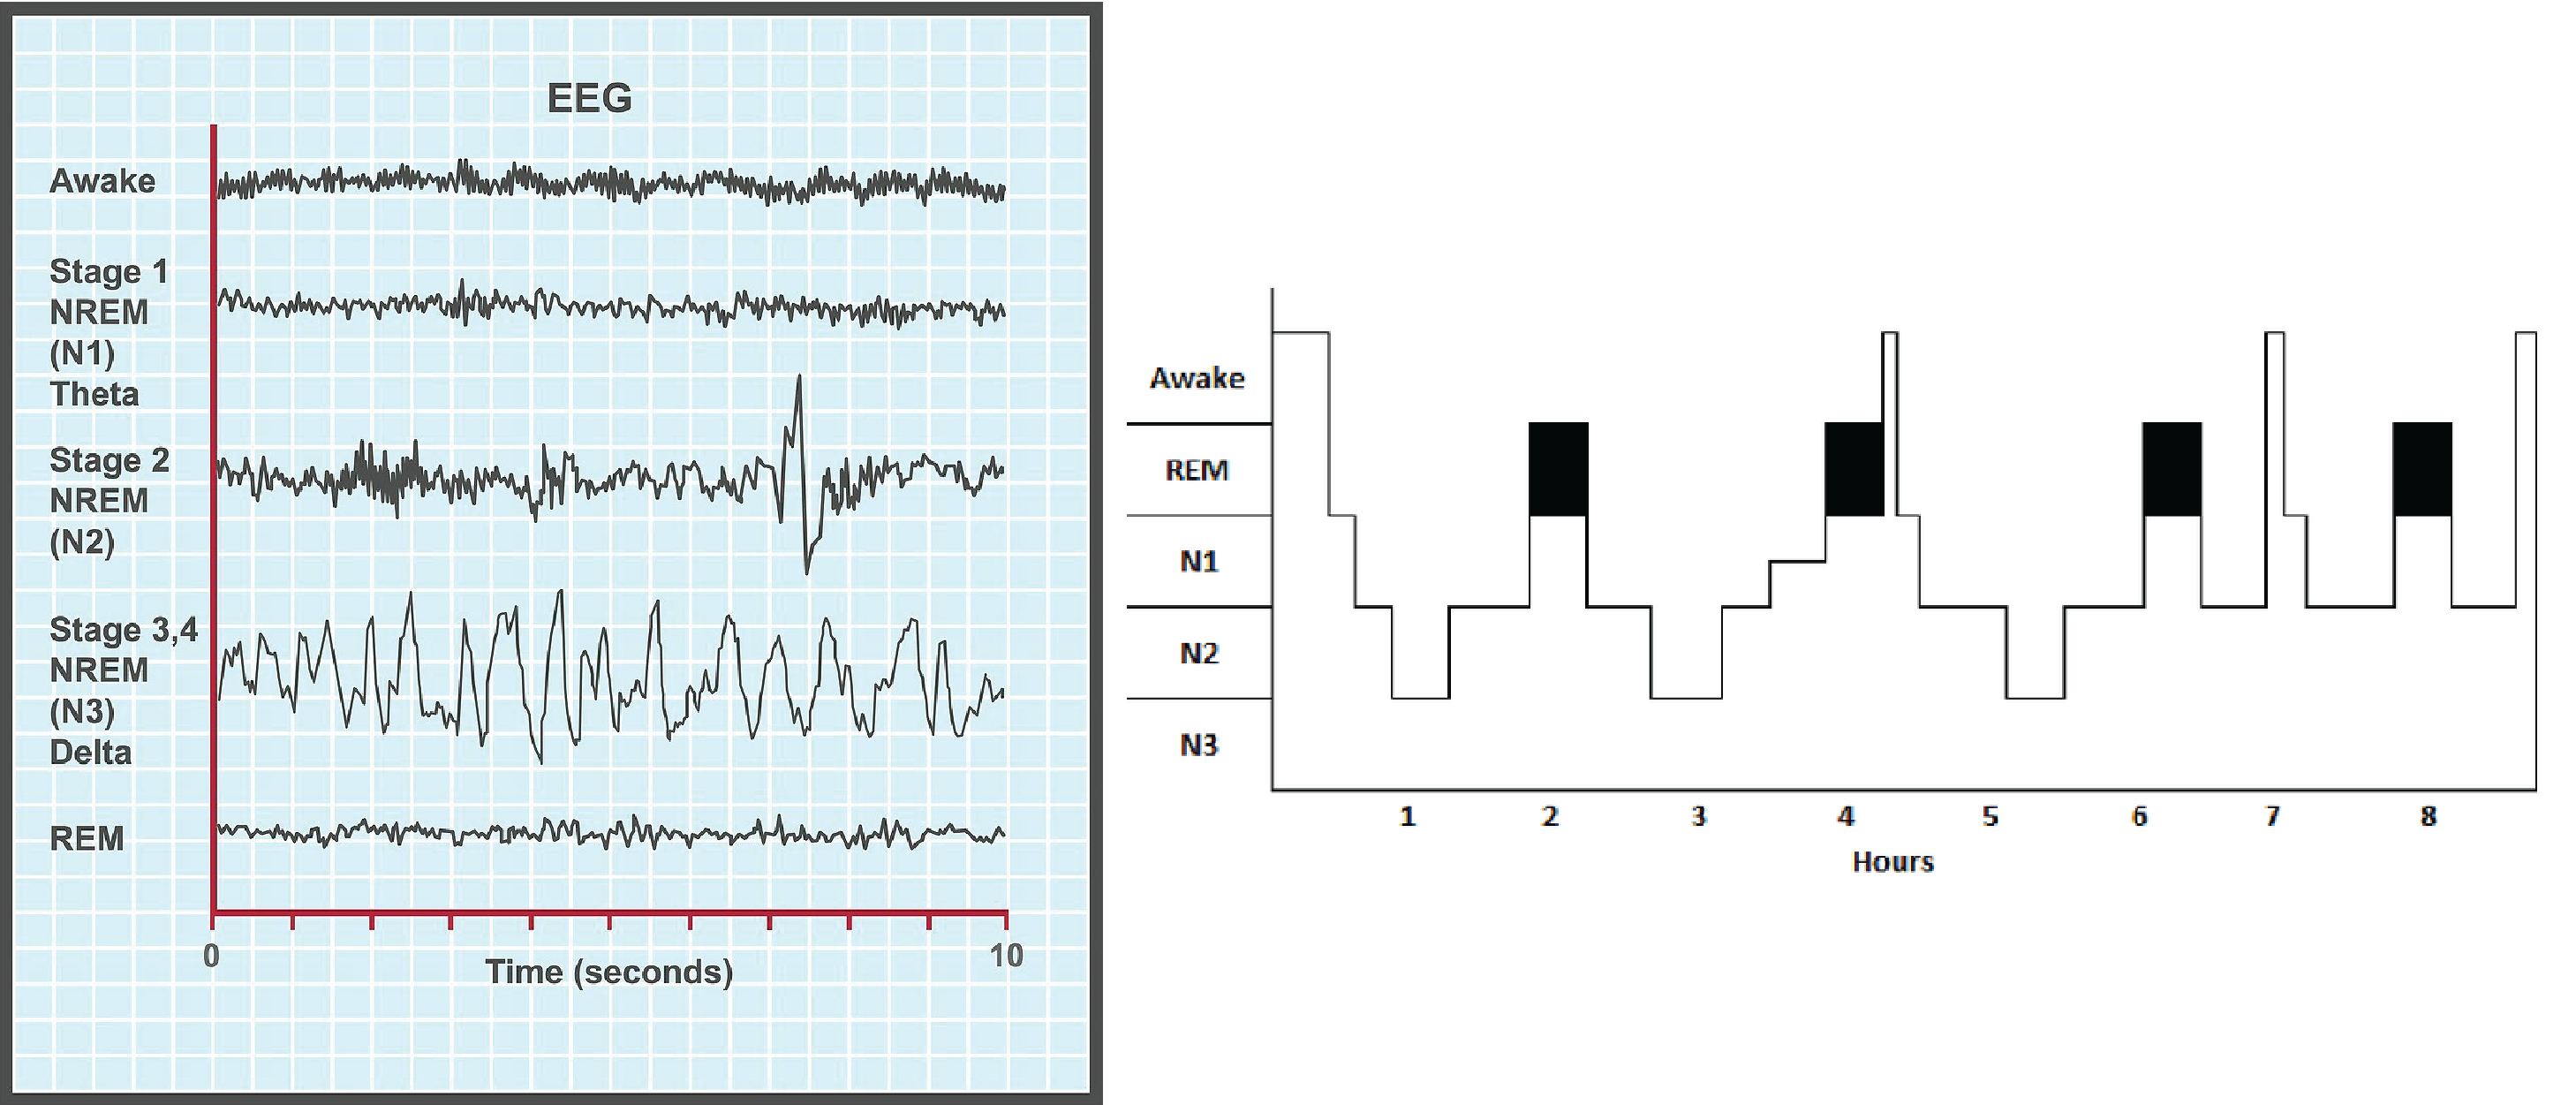
                    
                    Fig 2. EEG pattern of sleep stages(left), Sleep stages with  time(right)

In [ ]:
def butter_bandpass(lowcut, highcut,fs=50, order=5):
    nyq = 0.5*fs # Nyquist Rate
    low = lowcut/nyq 
    high = highcut/nyq 
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def apply_filters(x):
    #delta filter 
    b, a = butter(N=5, Wn=4/25, btype ='lowpass')
    delta = lfilter(b, a, x)
    
    #theta filter
    b, a = butter_bandpass(4,8)
    theta = lfilter(b,a,x)
    
    #alpha filter
    b, a= butter_bandpass(8,13)
    alpha = lfilter(b,a,x)
    
    #beta filter
    b, a = butter_bandpass(13,22)
    beta = lfilter(b,a,x)
    
    #gamma filter
    b, a = butter(N=5, Wn=1/2 , btype="highpass")
    gamma = lfilter(b,a,x)
    return delta, theta, alpha, beta, gamma

## Function for Visualisation

In [ ]:
def Spectrofilter(signal, Fs = 50):
    delta, theta, alpha, beta, gamma = apply_filters(signal)
        
    plt.subplot(6,1,1)
    array = plt.magnitude_spectrum(signal,Fs)
    plt.ylabel('signal')

    plt.subplot(6,1,2)
    plt.magnitude_spectrum(delta,Fs)
    plt.ylabel('delta')

    plt.subplot(6,1,3)
    plt.magnitude_spectrum(theta,Fs)
    plt.ylabel('theta')

    plt.subplot(6,1,4)
    plt.magnitude_spectrum(alpha,Fs)
    plt.ylabel('alpha')

    plt.subplot(6,1,5)
    plt.magnitude_spectrum(beta,Fs)
    plt.ylabel('beta')

    plt.subplot(6,1,6)
    plt.magnitude_spectrum(gamma,Fs)
    plt.ylabel('gamma')

    ax=plt.gca()

    plt.show()

## Feature Extracting Functions
Here we extract the statistical features of the particular frequency bands and not the entire signal. By doing this we eliminate noisy components of the entire signal and just take into account the part of interest. In this method, we hope to extract features particular to a sleep stage so that we have more accuracy while comparing the features with the test data. For example, it would be better to compare the mean of delta stage signals in both the train and test data than to just compare the mean of the entire signals which would be meaningless.

Among the robust list of features, we have 2 main features of interest which are used to characterize signals:

$\bullet$ DMM :The first characteristic that we want to extract is called Maximum-Minimum Distance (MMD). It is a measure of the distance between the local minimum and maximum of the signal on each sliding window.

$\bullet$ Esis: Energy of the signal which is the product of velocity of the signal and its square at every point.

In [ ]:
def DMM(x):
    lambda_ = len(x)//10
    d = 0
    for i in range(10):
        xmin = np.argmin(x[lambda_*i: lambda_*(i+1)])
        xmax = np.argmax(x[lambda_*i: lambda_*(i+1)])
        ymin = np.min(x[lambda_*i: lambda_*(i+1)])
        ymax = np.max(x[lambda_*i: lambda_*(i+1)])
        d += ((xmax-xmin)**2+(ymax-ymin)**2)**0.5
    return d 

def Esis(X,v):
    return(np.sum([X[i]**2 for i in range(len(X))])*v)

def mean(x): 
    return fc.mean(x)

def variance(x):
    return fc.variance(x)

def kurtosis(x):
    return fc.kurtosis(x)

def skewness(x):
    return fc.skewness(x)

def sample_entropy(x):
    return fc.sample_entropy(x)

def abs_energy(x):
    return fc.abs_energy(x)

def first_quantile(x): 
    return fc.quantile(x,1/4)

def median(x):
    return fc.median(x)

def third_quantile(x):
    return fc.quantile(x,3/4)

def IQR(x):
    return first_quantile(x)-third_quantile(x)

def mode(x):
    unique, counts = np.unique(x, return_counts=True)
    return unique[np.argmax(counts)]

## Accessing datasets

In [5]:
path = sys.getcwd()
path_X_train= path +'\data\X_train.h5'
path_y_train= path +'\data\y_train.csv'
path_X_test = path +'\data\X_test.h5'

Y = pd.read_csv(path_y_train)
X_train = h5py.File(path_X_train,'r')
print(X_train.keys()) #viewing the data to get an idea

<KeysViewHDF5 ['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6', 'index', 'x', 'y', 'z']>


### Description of the data
We have 5 eeg channels which give us the brain activity in each region its being measured and we have three accelerometer data which gives us an idea about how the patient is moving during the sleep. As the patient is wearing the DREEM Headband, we get the data about the head movement.

## Visualizing the signal
Here we can see the main signal and its constituents broken down into different frequency bands. From this, we can say that all different sleep stage signals are making up the 30 second EEG signal.

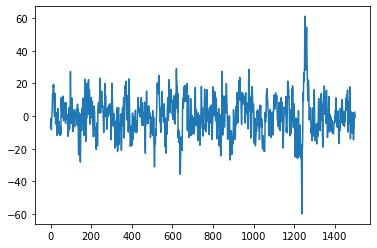

In [6]:
test_sig = X_train["eeg_1"][168]
plt.plot(test_sig)
plt.show()

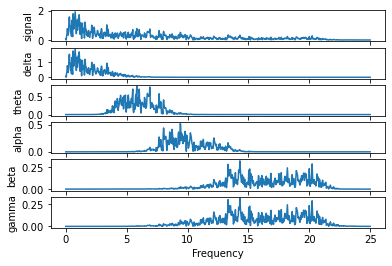

In [7]:
Spectrofilter(test_sig)

## Feature Extraction
In this step, we extract the features we discussed above from all the signals in both the datasets, train and test, and create a robust dataframe consisting of all the features for further model training and classification. We define 2 functions which help us do the same.

In [8]:
# function capable of extracting a feature for all the different frequency band signals
def func_exec(func,sig_list):
    oplist = []
    for sig in sig_list:
        oplist.append(func(sig))
    return oplist

In [9]:
def extractFeatures(X, sig_len):
    masterL=[]
    #sig_len = len(X['eeg_1'])
    func_list = [DMM,mean,variance,kurtosis,skewness,abs_energy,first_quantile,median,third_quantile,IQR,mode]

    for i in tq.tqdm(range(sig_len)):

        sigFeatures=[]
        ID = X['index'][i]
        sigFeatures.append(ID)

        # Extracting Features of eeg signals

        for j in [1,2,4,5,6]:
            sign = "eeg_"+str(j)

            signal_j = X[sign][i]

            delta_j, theta_j, alpha_j, beta_j, gamma_j = apply_filters(signal_j)
            sig_list = [delta_j, theta_j, alpha_j, beta_j, gamma_j]

            for func in func_list:
                sigFeatures = sigFeatures + func_exec(func,sig_list)

            sigFeatures = sigFeatures + [Esis(delta_j,2*len(delta_j)//10),
                                    Esis(theta_j,6*len(theta_j)//10),
                                    Esis(alpha_j,10.5*len(alpha_j)//10),
                                    Esis(beta_j,17.5*len(beta_j)//10),
                                    Esis(gamma_j,30*len(gamma_j)//10)]

        # Extracting features of x,y,z

        sig_left = ['x','y','z']

        for sig in sig_left:

            signal = X[sig][i]

            sigFeatures = sigFeatures + [ mean(signal),variance(signal),kurtosis(signal),skewness(signal),
                                abs_energy(signal),first_quantile(signal),median(signal),
                                third_quantile(signal),IQR(signal),mode(signal)]

        masterL.append(sigFeatures)

    masterL=np.array(masterL)

    Features_List = ["DMM","Mean","Variance","Kurtosis","Skewness","Abs_energy",
                    "First_quantile","Median","Third_quantile","IQR","Mode","Esis"]
    SIGNALS = ["eeg","x","y","z"]

    column_names = ["index"]

    for signal in SIGNALS :

        if(signal == "eeg"):
            for i in [1,2,4,5,6]:
                for feature in Features_List:
                    column_names = column_names + [ signal+'_'+str(i)+'_'+"Delta"+'_'+feature,
                                                  signal+'_'+str(i)+'_'+"Theta"+'_'+feature,
                                                  signal+'_'+str(i)+'_'+"Alpha"+'_'+feature,
                                                  signal+'_'+str(i)+'_'+"Beta"+'_'+feature,
                                                  signal+'_'+str(i)+'_'+"Gamma"+'_'+feature]
        else:
            for feature in Features_List[1:11]:
                column_names = column_names + [signal+'_'+feature]
                
    df = pd.DataFrame(masterL, columns = column_names)
    return df

In both the cases below, we used just 1000 signals from the dataset just to illustrate the working, however, the entire training and testing of the model was done with the entire dataset which was then used to classify the test data for submission.

In [10]:
df_train = extractFeatures(X_train,len(X_train['eeg_1'])
df_train.to_csv("features_train.csv",index=False)
print("Number of Features Extracted:", len(df_train.keys()[1:]))
all_features = df_train.keys()[1:]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of Features Extracted: 330


In [11]:
X_test = h5py.File(path_X_test,'r')
df_test = extractFeatures(X_test,len(X_test['eeg_1']))
df_test.to_csv("features_test.csv",index=False)
print("Number of Features Extracted:", len(df_test.keys()[1:]))
all_features = df_test.keys()[1:]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of Features Extracted: 330


## Classifier Training and Optimization

Classifiers used: SVM, RandomForest, ExtraTrees, Light GBM, XGBoost.
After optimizng the classifiers, we using VotingClassifier to get a higher accuracy.

Cross Validation method: Stratified K-Folds cross-validator.

This method provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. Here we use 10 folds for all our cross validations.

## SVM

In [12]:
#SVM CROSS VALIDATION
from sklearn import svm
model1 = svm.SVC(kernel='rbf', gamma ='auto')
cv_results = cross_validate(model1, df_train[all_features],Y['sleep_stage'], cv=10)
print("Averge score of SVM via cross validation method:", cv_results['test_score'].mean(), "with Max Accuracy:",
      cv_results['test_score'].max())

Averge score of SVM via cross validation method: 0.35300000000000004 with Max Accuracy: 0.36


## Random Forest

In [13]:
model2 = RandomForestClassifier(max_depth=7, random_state=0, n_estimators=150)
cv_results = cross_validate(model2, df_train[all_features],Y['sleep_stage'], cv=10)
print("Averge score of RF via cross validation method:", cv_results['test_score'].mean(), "with Max Accuracy:",
      cv_results['test_score'].max())

Averge score of RF via cross validation method: 0.573 with Max Accuracy: 0.67


## ExtraTrees

ExtraTrees is named for (Extremely Randomized Trees) is an ensemble learning method fundamentally based on decision trees. ExtraTreesClassifier, like RandomForest, randomizes certain decisions and subsets of data to minimize over-learning from the data and overfitting.
Random Forest chooses the optimum split while Extra Trees chooses it randomly.

When comparing the ensemble methods ordered from high to low variance, we get Decision Tree >> Random Forest >> Extra Trees.


A single decision tree is usually overfits the data it is learning from because it learn from only one pathway of decisions. Predictions from a single decision tree usually don’t make accurate predictions on new data. 

Random forest models reduce the risk of overfitting by introducing randomness by building multiple trees (n_estimators), drawing observations with replacement (i.e., a bootstrapped sample), splitting nodes on the best split among a random subset of the features selected at every node.

Extra Trees is like Random Forest, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits. 

So, in summary, ExtraTrees builds multiple trees without bootstrapping, meaning it samples without replacement
nodes are split based on random splits among a random subset of the features selected at every node
In Extra Trees, randomness doesn’t come from bootstrapping of data, but rather comes from the random splits of all observations. 

In [14]:
model3 = ExtraTreesClassifier(n_estimators=240,random_state = 410)
cv_results = cross_validate(model3, df_train[all_features],Y['sleep_stage'], cv=10)
print("Averge score of ET via cross validation method:", cv_results['test_score'].mean(), "with Max Accuracy:",
      cv_results['test_score'].max())

Averge score of ET via cross validation method: 0.6020000000000001 with Max Accuracy: 0.72


## Light GBM

### What is Light GBM?
It is a gradient boosting framework that makes use of tree based learning algorithms that is considered to be a very powerful algorithm when it comes to computation. It is considered to be a fast processing algorithm. 

While other algorithms trees grow horizontally, LightGBM algorithm grows vertically meaning it grows leaf-wise and other algorithms grow level-wise. LightGBM chooses the leaf with large loss to grow. It can lower down more loss than a level wise algorithm when growing the same leaf.

### Why use Light GBM?
It is designed to be distributed and efficient with the following advantages:

$\bullet$Faster training speed and higher efficiency.

$\bullet$Lower memory usage.

$\bullet$Better accuracy.

$\bullet$Support of parallel, distributed, and GPU learning.

$\bullet$Capable of handling large-scale data.

It is not advisable to use LGBM on small datasets. Light GBM is sensitive to overfitting and can easily overfit small data.

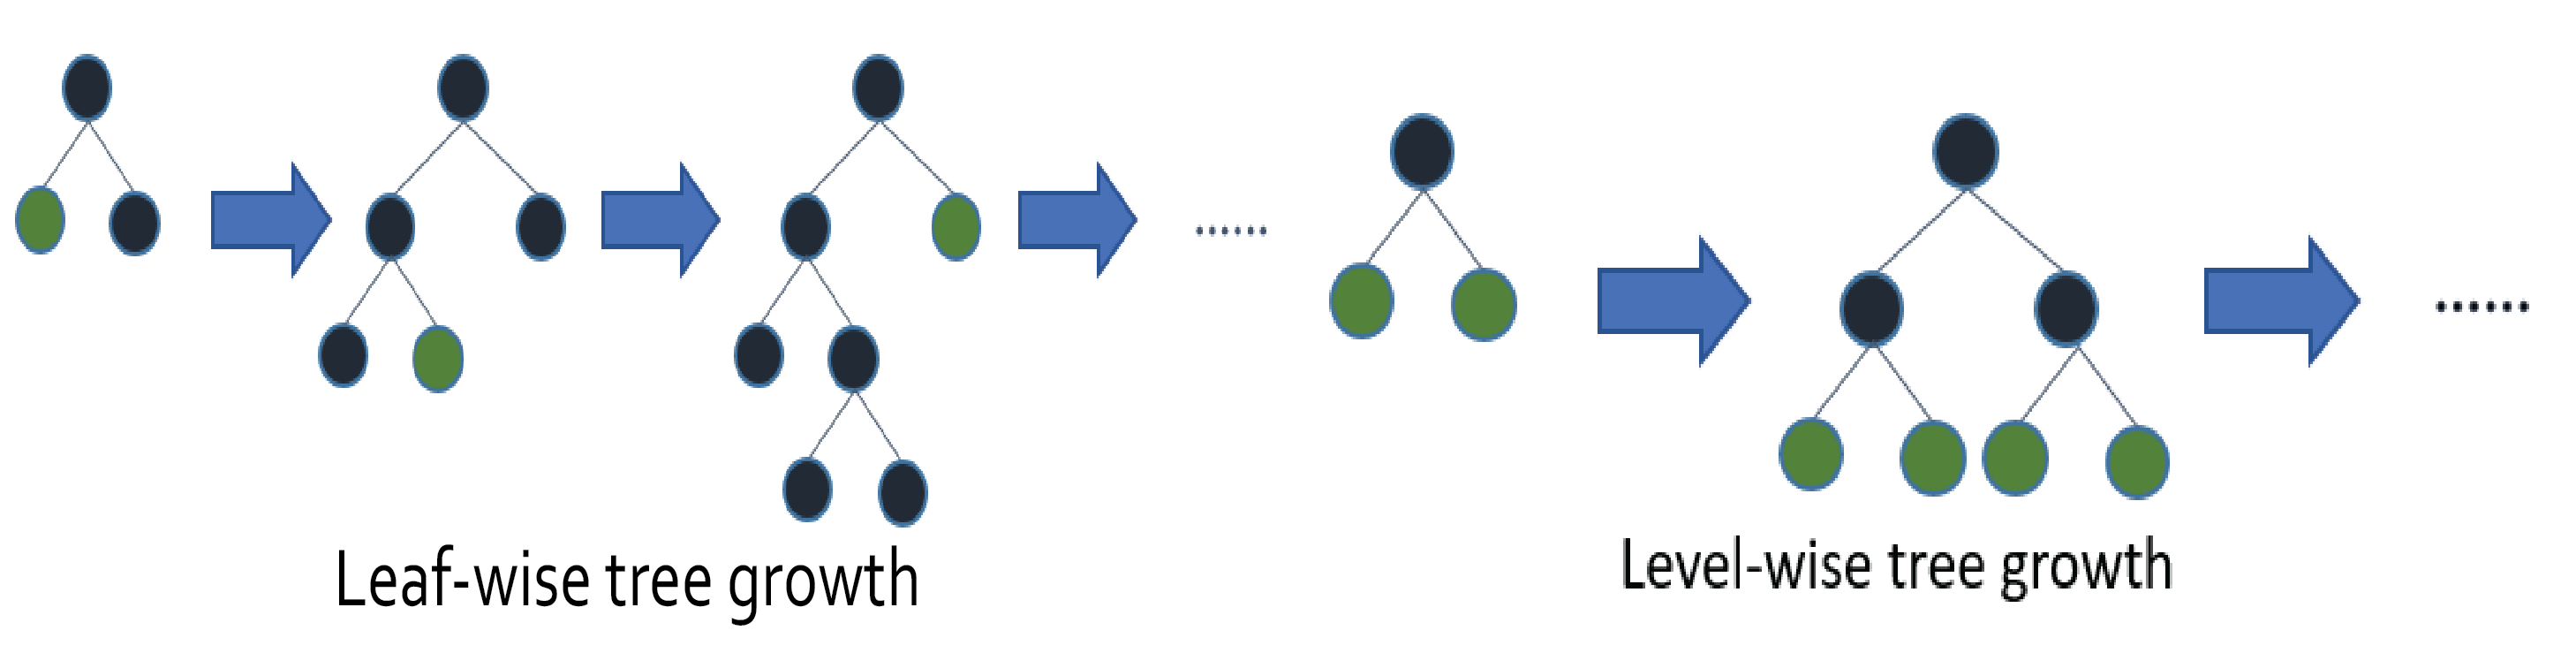

          Fig 3. Showing leafwise growth(Light GBM) vs levelwise growth(Other decision tree algorithms)

In [15]:
model4 = lgb.LGBMClassifier()
cv_results = cross_validate(model4, df_train[all_features],Y['sleep_stage'], cv=10)
print("Averge score of LGBM via cross validation method:", cv_results['test_score'].mean(), "with Max Accuracy:",
      cv_results['test_score'].max())

Averge score of LGBM via cross validation method: 0.572 with Max Accuracy: 0.71


## XGBoost

XGBoost stands for “Extreme Gradient Boosting”. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. It provides a parallel tree boosting to solve many data science problems in a fast and accurate way. 

Gradient boosting is one of the most powerful techniques for building predictive models. The main objective of Gradient Boost is to minimize the loss function by adding weak learners using a gradient descent optimization algorithm.

XGBoost the Algorithm operates on decision trees, models that construct a graph that examines the input under various "if" statements (vertices in the graph). Whether the "if" condition is satisfied influences the next "if" condition and eventual prediction. XGBoost the Algorithm progressively adds more and more "if" conditions to the decision tree to build a stronger model.

The key difference in speed is because XGBoost split the tree nodes one level at a time and LightGBM does that one node at a time.

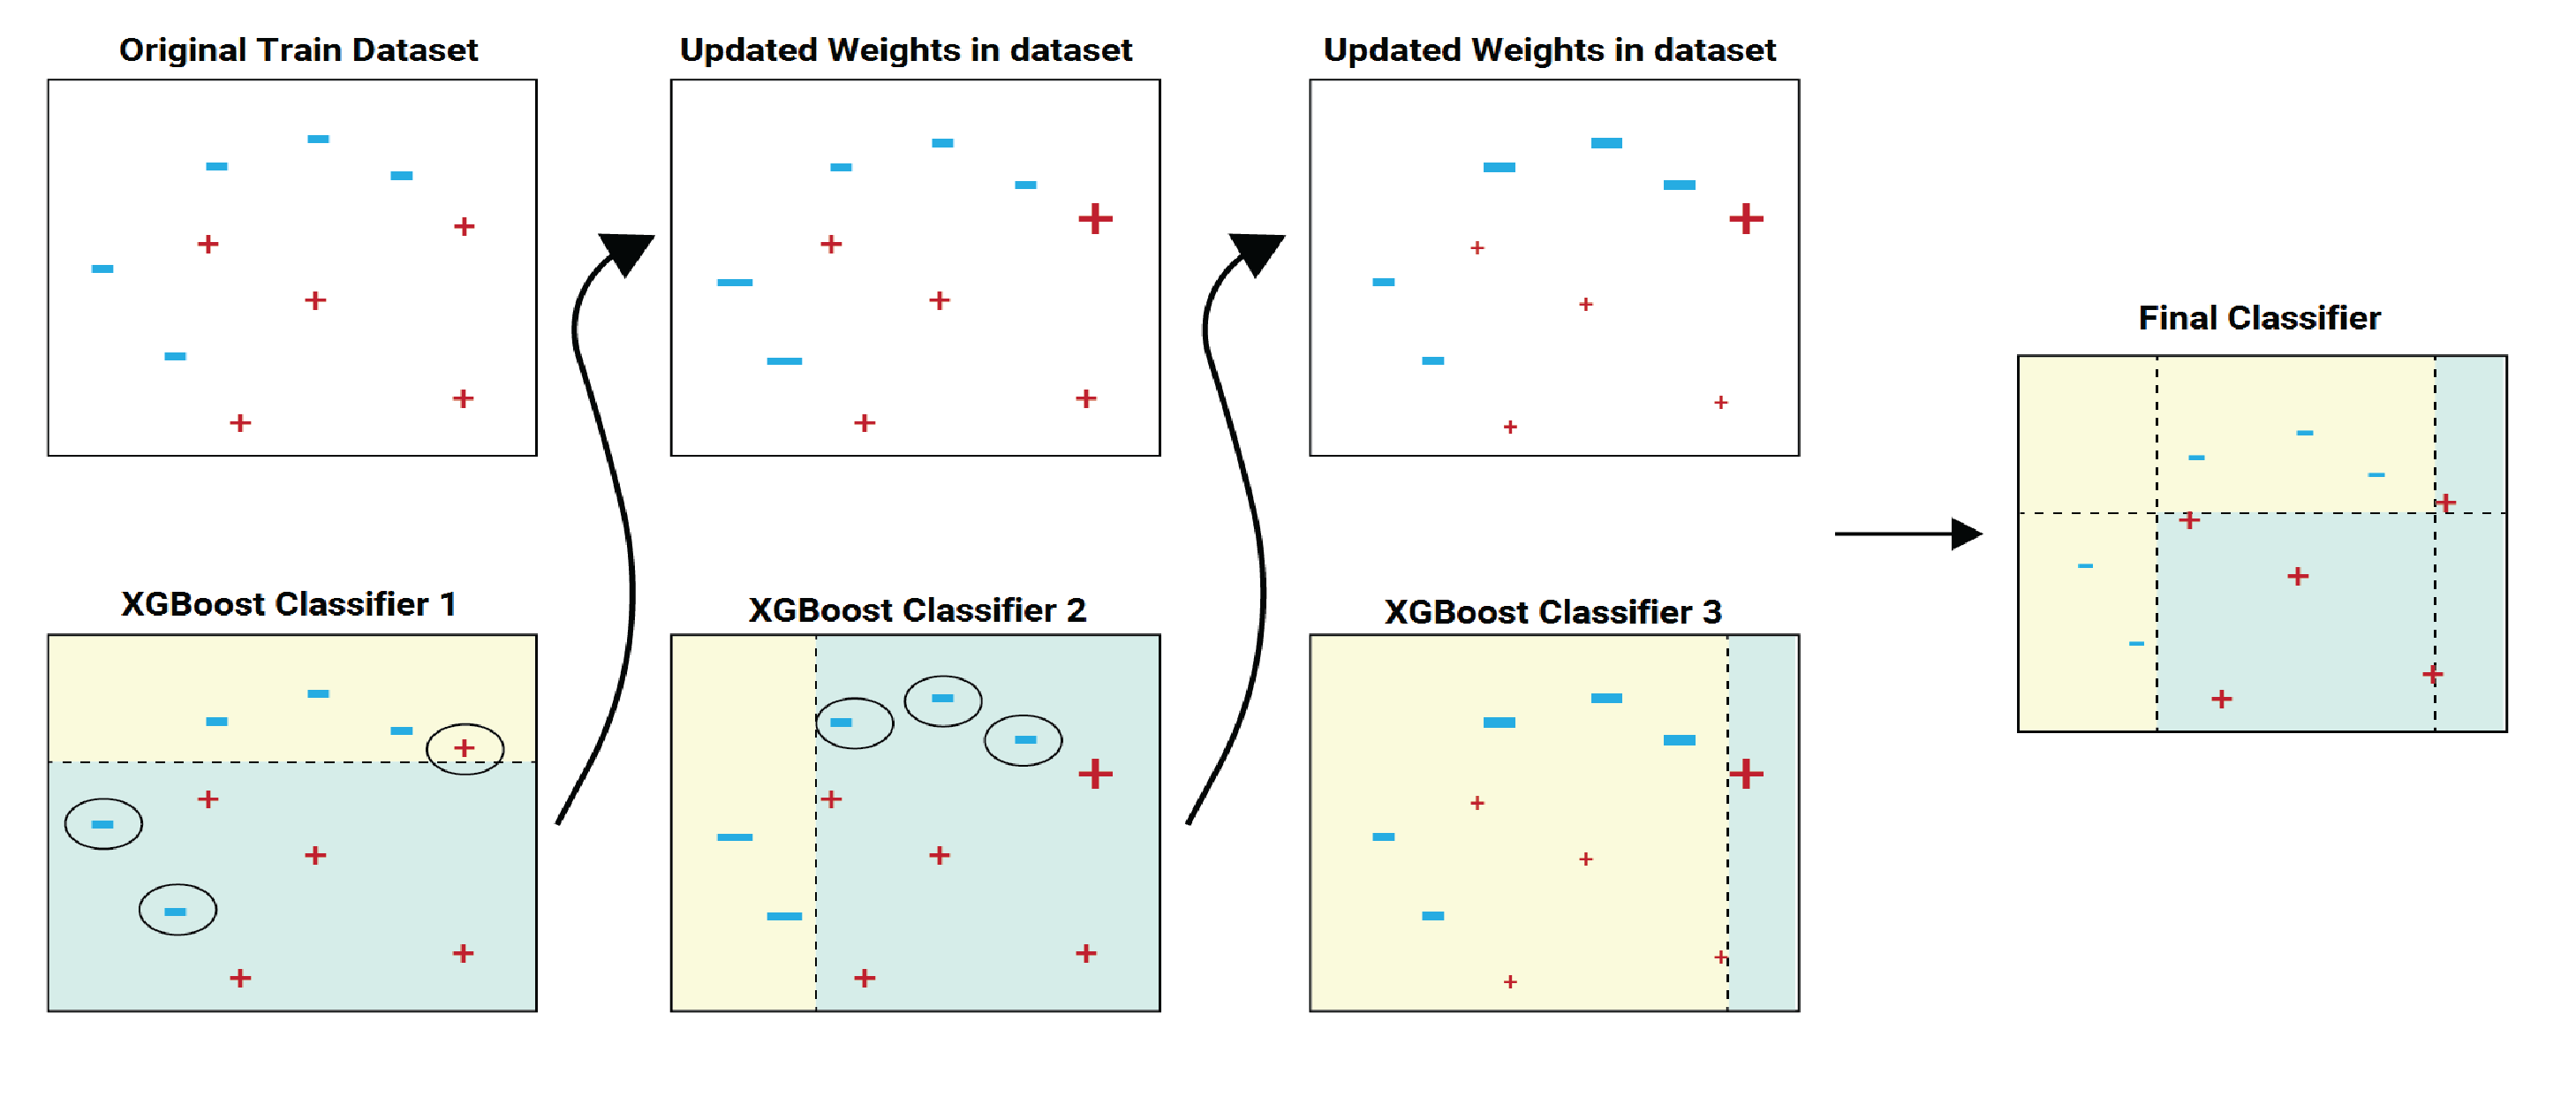

                                        Fig 4. Classification of data by XGBoost

In [16]:
model5 = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')
cv_results = cross_validate(model5, df_train[all_features],Y['sleep_stage'], cv=10)
print("Averge score of XGB via cross validation method:", cv_results['test_score'].mean(), "with Max Accuracy:",
      cv_results['test_score'].max())

Averge score of XGB via cross validation method: 0.55 with Max Accuracy: 0.63


## Optimising models

## Preparing data for Optimization

In [2]:
df_train = pd.read_csv("features_train.csv")
y = pd.read_csv("y_train.csv")
df_test = pd.read_csv("features_test.csv")

In [3]:
df_train['sleep_stage'] = y['sleep_stage']

In [4]:
X = df_train[df_train.keys()[1:331]]
y = df_train['sleep_stage']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Random Forest

In [6]:
rfc=RandomForestClassifier(random_state=42)

In [7]:
param_grid = { 
    'n_estimators': [100,200,300,400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

In [10]:
acc_list = []
n_list = []
for n in  [4,5,6,7,8,9,10]:
    #print(n)
    model3 = rfc=RandomForestClassifier(random_state=42, n_estimators=500, max_depth = n)
    model3.fit(X_train,y_train)
    y_pred = model3.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    n_list.append(n)
    print(n,accuracy_score(y_test, y_pred))

4 0.6203333333333333
5 0.647
6 0.6696666666666666
7 0.6866666666666666
8 0.6956666666666667
9 0.709
10 0.7173333333333334


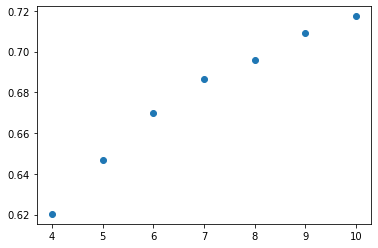

In [11]:
plt.scatter(n_list, acc_list)
plt.show()

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
y_pred = rfc1.predict(X_test)
accuracy_score(y_test, y_pred)

## Extra Trees

In [ ]:
# param_grid = {
#         'n_estimators': [150,200,250,300,350],
#         'max_features': [150,200,250,300,350],
#         'min_samples_leaf': range(20,51,5),
#         'min_samples_split': range(15,36,5),
# }

Due to the lack of computational power, using GridSearchCV will compute 600 x CV fits and assuming 40 seconds per fit, the total computation takes about 67 hours! The number will go up for Light GBM and XGBoost, so  we optimize it manually. 
We take one parameter, check for high accuracy and keep on adding the next parameter to improve accuracy of the model.

In [ ]:
acc_list = []
n_list = []
for n in range(60,501,20):
    print(n)
    model3 = ExtraTreesClassifier(n_estimators=n)
    model3.fit(X_train,y_train)
    y_pred = model3.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    n_list.append(n)

In [ ]:
plt.scatter(n_list, acc_list)
plt.show()

Best Parameters ==> n_estimators = 240; Rest brought down the accuracy (74.3%)

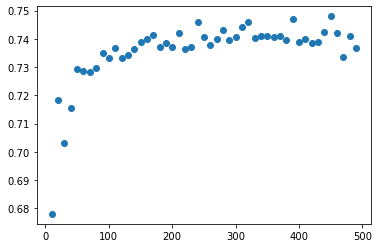

In [23]:
modelET = ExtraTreesClassifier(n_estimators=240)
modelET.fit(X_train,y_train)
y_pred = modelET.predict(X_test)
print("Accuracy of  ET:", accuracy_score(y_test, y_pred))

Accuracy of  ET: 0.743


## Light GBM

In [ ]:
# param_grid = {
#     'n_estimators': [250, 400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'min_split_gain': [0.3, 0.4],
#     'subsample': [0.7, 0.8, 0.9],
#     'subsample_freq': [20]
# }

In [ ]:
acc_list = []
n_list = []
for n in range(10,101,10):
    model3 = lgb.LGBMClassifier(n_estimators= 375, num_leaves = 110,max_depth = n)
    model3.fit(X_train,y_train)
    y_pred = model3.predict(X_test)
    print(n)
    acc_list.append(accuracy_score(y_test, y_pred))
    n_list.append(n)

In [ ]:
plt.scatter(n_list, acc_list)
plt.show()

Best Parameters ==> n_estimators = 375, num_leaves = 110, max_depth = 30 ; Rest brought down the accuracy (75.4%)

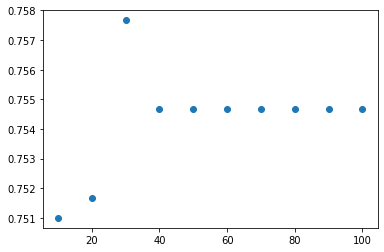

In [24]:
modelg = lgb.LGBMClassifier(n_estimators= 375,num_leaves = 110,max_depth = 30)
modelg.fit(X_train, y_train)
y_pred=modelg.predict(X_test)
print("Accuracy of LGBM :", accuracy_score(y_test, y_pred))

Accuracy of LGBM : 0.754


## XGBoost

In [ ]:
# param_grid = {
#     'n_estimators': [100, 250, 400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'subsample': [0.7, 0.8, 0.9]
# }

In [ ]:
acc_list = []
n_list = []
for n in range(50,501,25):
    model3 = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss',n_estimators= n)
    model3.fit(X_train,y_train)
    y_pred = model3.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    n_list.append(n)
    print(n,acc)

In [ ]:
plt.scatter(n_list, acc_list)
plt.show()

Best Parameters ==> n_estimators = 400; Rest brought down the accuracy (74.97%)

In [25]:
modelx = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss',n_estimators=400)
                           #colsample_bytree = 0.3)
modelx.fit(X_train,y_train)
y_pred = modelx.predict(X_test)
print("Accuracy of XGBoost :", accuracy_score(y_test, y_pred))

Accuracy of XGBoost : 0.7496666666666667


## Voting Classifer - Majority Voting
The Voting Classifier takes into account all the three top performing classifier Extra Trees, Light GBM and XGBoost and compare their outputs provides us with an output which is same across the classifiers.

In [26]:
clf1 = ExtraTreesClassifier(n_estimators=240)
clf2 = lgb.LGBMClassifier(n_estimators= 375,num_leaves = 110,max_depth = 30)
clf3 = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss',n_estimators=400)

In [27]:
eclf1 = VotingClassifier(estimators=[('et', clf1), ('lgbm', clf2), ('xgb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)
print("Accuracy of Voting :", accuracy_score(y_test, y_pred))

Accuracy of Voting : 0.7533333333333333


In [29]:
eclf2 = VotingClassifier(estimators=[('et', clf1), ('lgbm', clf2), ('xgb', clf3)], voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
y_pred = eclf2.predict(X_test)
print("Accuracy of Voting Soft:", accuracy_score(y_test, y_pred))

Accuracy of Voting Soft: 0.7543333333333333


In [30]:
eclf3 = VotingClassifier(estimators=[('et', clf1), ('lgbm', clf2), ('xgb', clf3)], voting='soft', weights=[0.8,1.8,1.2], flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)
print("Accuracy of Voting Soft with Weights:", accuracy_score(y_test, y_pred))

Accuracy of Voting Soft with Weights: 0.7523333333333333


## Making Predictions using Optimal model
We see that model eclf2 has the highest accuracy with 75.43% while testing, so we use that model to classify the test data.

In [31]:
df_test = pd.read_csv("features_test.csv")
y_preds = eclf2.predict(df_test[df_test.keys()[1:]])
y_df = pd.DataFrame(np.arange(len(y_preds))+15000, columns =["index"])
y_df["sleep_stage"] = y_preds
y_df.to_csv("finalpreds_.csv", index=False)

## Final Results
We visualize the results obtained so far and can say Light GBM and Voting Classifier Soft performed really well with an accuracy of ~75.4%. Thus, we used the VC Soft model for classification of test data and got a result of 70.32% accuracy.

| Models | Accuracy  |
|------|------|
| SVM | 0.36  |
| RandomForest | 0.67  |
| ExtraTrees | 0.743 |
| Light GBM  | 0.754|
| XGBoost | 0.749  |
| Voting Hard | 0.753 |
| Voting Soft  | 0.754|
| Voting Soft with Weights | 0.752  |